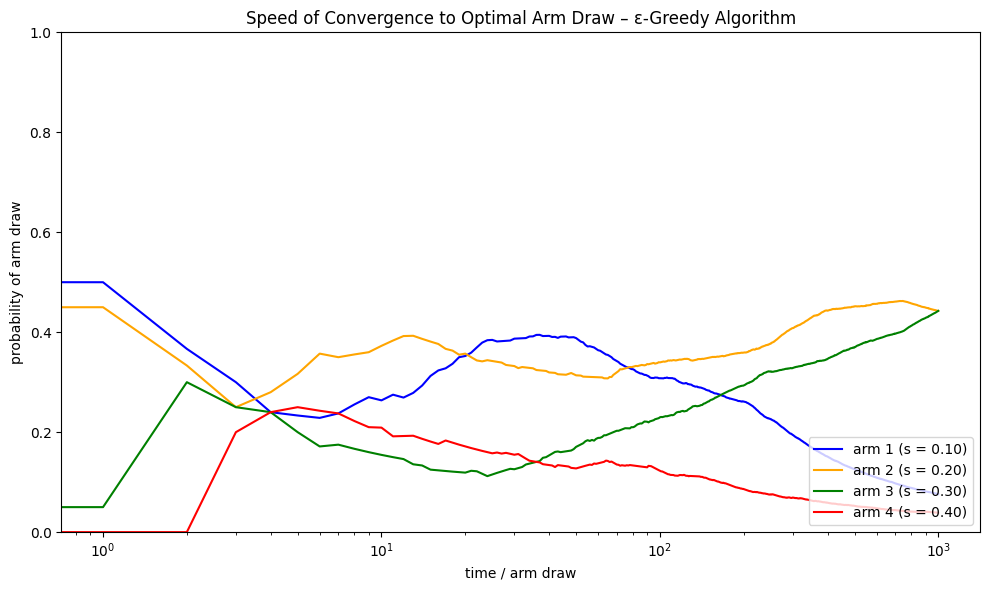

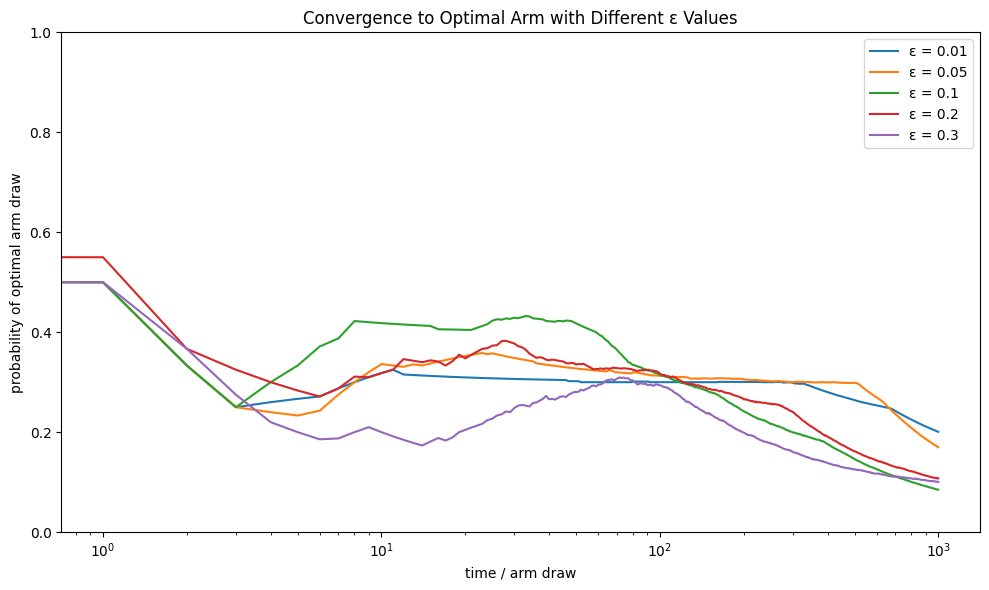

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Settings
T = 1000
n_agents = 10
price_options = [0.1, 0.2, 0.3, 0.4]
conversion_rates = [0.9, 0.6, 0.4, 0.2]
K = len(price_options)

def get_reward(price_index):
    prob = conversion_rates[price_index]
    return price_options[price_index] if np.random.rand() < prob else 0

def simulate_epsilon_greedy(epsilon=0.1):
    counts_over_time = np.zeros((K, T))
    for agent in range(n_agents):
        n_k = np.zeros(K)
        r_k = np.zeros(K)
        
        for t in range(1, T+1):
            # ε-Greedy implementation
            if np.random.rand() < epsilon:
                # Exploration: choose randomly
                choice = np.random.choice(K)
            else:
                # Exploitation: choose best arm based on current estimates
                # For arms not yet pulled, assign high value to ensure they get pulled
                avg_rewards = np.array([r_k[k]/n_k[k] if n_k[k] > 0 else float('inf') for k in range(K)])
                choice = np.argmax(avg_rewards)
            
            reward = get_reward(choice)
            n_k[choice] += 1
            r_k[choice] += reward
            counts_over_time[choice, t-1] += 1
    
    return counts_over_time / n_agents

# Run ε-Greedy simulation
egreedy_p = np.cumsum(simulate_epsilon_greedy(epsilon=0.1), axis=1) / (np.arange(1, T+1))

# Plot ε-Greedy results
plt.figure(figsize=(10, 6))
colors = ['blue', 'orange', 'green', 'red']

for i in range(K):
    plt.plot(egreedy_p[i], label=f'arm {i+1} (s = {price_options[i]:.2f})', color=colors[i])

plt.xscale("log")
plt.ylim(0, 1)
plt.xlabel("time / arm draw")
plt.ylabel("probability of arm draw")
plt.title("Speed of Convergence to Optimal Arm Draw – ε-Greedy Algorithm")
plt.legend(loc="lower right")
plt.tight_layout()
plt.savefig("egreedy_convergence.png")
plt.show()

# Explore different epsilon values
epsilons = [0.01, 0.05, 0.1, 0.2, 0.3]
egreedy_results = []

for eps in epsilons:
    result = np.cumsum(simulate_epsilon_greedy(epsilon=eps), axis=1) / (np.arange(1, T+1))
    egreedy_results.append(result)

# Plot comparison of different epsilon values (focusing on the optimal arm)
plt.figure(figsize=(10, 6))
optimal_arm = 0  # Arm with highest expected reward (price_options[0] * conversion_rates[0])

for i, eps in enumerate(epsilons):
    plt.plot(egreedy_results[i][optimal_arm], label=f'ε = {eps}')

plt.xscale("log")
plt.ylim(0, 1)
plt.xlabel("time / arm draw")
plt.ylabel("probability of optimal arm draw")
plt.title("Convergence to Optimal Arm with Different ε Values")
plt.legend()
plt.tight_layout()
plt.savefig("egreedy_epsilon_comparison.png")
plt.show()

Running with ε=0.01
Running with ε=0.05
Running with ε=0.1
Running with ε=0.2
Running with ε=0.5


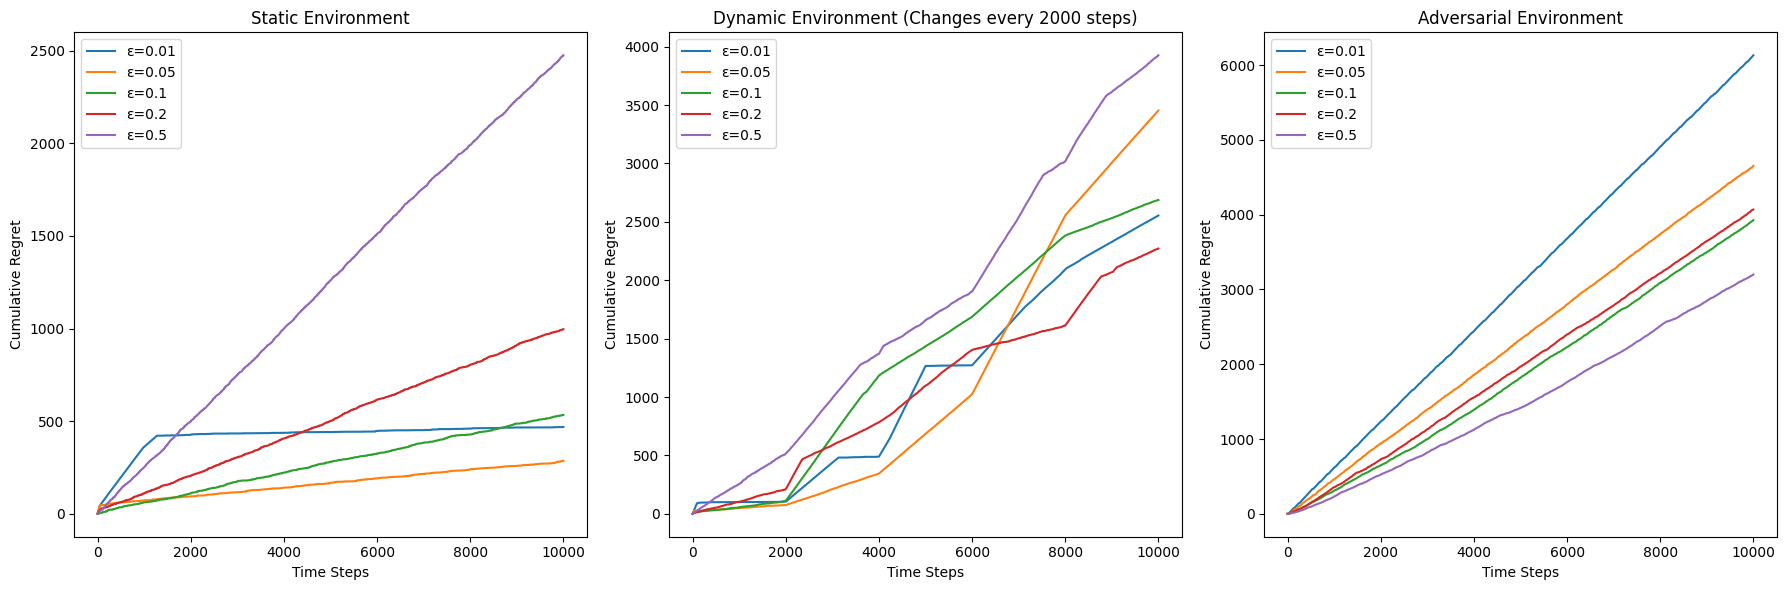

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Environment Classes
class BanditEnvironment:
    def __init__(self, num_arms, reward_means):
        """
        Standard multi-armed bandit environment with fixed reward probabilities
        
        Parameters:
        num_arms (int): Number of arms in the bandit environment
        reward_means (array): Array of reward probabilities for each arm
        """
        self.num_arms = num_arms
        self.reward_means = reward_means
        
    def pull_arm(self, arm):
        """
        Pull the specified arm and return reward based on its probability
        
        Parameters:
        arm (int): The arm to pull
        
        Returns:
        int: Reward (1 if successful, 0 otherwise)
        """
        return np.random.binomial(1, self.reward_means[arm])

class DynamicBanditEnvironment(BanditEnvironment):
    def __init__(self, num_arms, reward_means, change_interval=2000):
        """
        Dynamic environment that periodically shuffles reward probabilities
        
        Parameters:
        num_arms (int): Number of arms
        reward_means (array): Initial reward probabilities 
        change_interval (int): Number of steps between changes
        """
        super().__init__(num_arms, reward_means.copy())
        self.change_interval = change_interval
        self.time_step = 0
        self.original_means = reward_means.copy()
        
    def pull_arm(self, arm):
        """
        Pull arm and possibly change environment
        """
        self.time_step += 1
        if self.time_step % self.change_interval == 0:
            # Shuffle reward means to change optimal arm
            #np.random.shuffle(self.reward_means)
            shuffled_means = self.original_means.copy()
            np.random.shuffle(shuffled_means)
            self.reward_means = shuffled_means
        return super().pull_arm(arm)

class AdversarialBanditEnvironment(BanditEnvironment):
    def __init__(self, num_arms, base_reward=0.7, attack_strength=0.02):
        """
        Adversarial environment that reduces the reward probability of frequently chosen arms
        
        Parameters:
        num_arms (int): Number of arms
        base_reward (float): Initial reward probability for all arms 
        attack_strength (float): Penalty applied to pulled arms
        """
        super().__init__(num_arms, np.full(num_arms, base_reward))
        self.base_reward = base_reward
        self.attack_strength = attack_strength
        self.pull_counts = np.zeros(num_arms)
        
    def pull_arm(self, arm):
        """
        Pull arm and update environment to reduce reward probability for pulled arm
        """
        # Get reward before modifying probabilities
        reward = super().pull_arm(arm)
        
        # Update pull count
        self.pull_counts[arm] += 1
        
        # Reduce reward probability for pulled arm
        self.reward_means[arm] = max(0, self.reward_means[arm] - self.attack_strength)
        
        # Gradually restore other arms toward base reward
        for a in range(self.num_arms):
            if a != arm:
                self.reward_means[a] = min(
                    self.base_reward,
                    self.reward_means[a] + self.attack_strength/(self.num_arms-1)
                )
                
        return reward

# Epsilon-Greedy Algorithm
class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        """
        Epsilon-greedy algorithm for multi-armed bandits
        
        Parameters:
        num_arms (int): Number of arms
        epsilon (float): Probability of random exploration
        """
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.counts = np.zeros(num_arms)
        self.values = np.zeros(num_arms)
        
    def select_arm(self):
        """
        Select arm based on epsilon-greedy strategy
        """
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)
        else:
            return np.argmax(self.values)
        
    def update(self, arm, reward):
        """
        Update estimated value of selected arm
        """
        self.counts[arm] += 1
        self.values[arm] += (reward - self.values[arm]) / self.counts[arm]

# Experiment Function
def run_experiment(bandit_class, bandit_params, env, num_steps):
    """
    Run bandit experiment and compute cumulative regret
    
    Parameters:
    bandit_class: Class of bandit algorithm to use
    bandit_params: Parameters for the bandit algorithm
    env: Environment to run experiment in
    num_steps: Number of time steps to run
    
    Returns:
    array: Cumulative regret over time
    """
    bandit = bandit_class(**bandit_params)
    regrets = []
    
    for _ in range(num_steps):
        # Get current optimal arm before environment may change
        #current_optimal = max(env.reward_means)
        
        # Select arm and get reward
        arm = bandit.select_arm()
        reward = env.pull_arm(arm)
        
        # Get current optimal arm before environment may change
        current_optimal = max(env.reward_means)

        # Calculate regret and update algorithm
        regret = current_optimal - env.reward_means[arm]  # Expected regret
        regrets.append(regret)
        bandit.update(arm, reward)
        
    return np.cumsum(regrets)

# Main experiment runner
def run_epsilon_greedy_experiments():
    # Experimental setup
    num_arms = 10
    base_reward_means = np.linspace(0, 1, num_arms)
    num_steps = 10000
    
    # Create environments
    # static_env = BanditEnvironment(num_arms, base_reward_means.copy())
    # dynamic_env = DynamicBanditEnvironment(num_arms, base_reward_means.copy(), change_interval=2000)
    # adv_env = AdversarialBanditEnvironment(num_arms, base_reward=0.7, attack_strength=0.02)
    
    # Epsilon values to test
    epsilon_values = [0.01, 0.05, 0.1, 0.2, 0.5]
    
    # Run experiments in each environment
    results = {
        "static": {},
        "dynamic": {},
        "adversarial": {}
    }
    
    # Test different epsilon values
    for epsilon in epsilon_values:
        name = f"ε={epsilon}"
        params = {"num_arms": num_arms, "epsilon": epsilon}
        
        print(f"Running with {name}")
        
        # Create environments
        static_env = BanditEnvironment(num_arms, base_reward_means.copy())
        dynamic_env = DynamicBanditEnvironment(num_arms, base_reward_means.copy(), change_interval=2000)
        adv_env = AdversarialBanditEnvironment(num_arms, base_reward=0.7, attack_strength=0.02)
        # Static environment
        results["static"][name] = run_experiment(
            EpsilonGreedy, 
            params, 
            static_env, 
            num_steps
        )
        
        # Dynamic environment
        results["dynamic"][name] = run_experiment(
            EpsilonGreedy, 
            params, 
            dynamic_env, 
            num_steps
        )
        
        # Adversarial environment
        results["adversarial"][name] = run_experiment(
            EpsilonGreedy, 
            params, 
            adv_env, 
            num_steps
        )
    
    # Plot results
    plot_results(results, num_steps)
    
def plot_results(results, num_steps):
    """
    Plot results from all experiments
    
    Parameters:
    results: Dictionary containing results for each environment and algorithm
    num_steps: Number of steps in each experiment
    """
    # Create figure with 3 subplots (one per environment)
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # Plot static environment results
    ax = axes[0]
    for algo_name, regret in results["static"].items():
        ax.plot(regret, label=algo_name)
    ax.set_title("Static Environment")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Cumulative Regret")
    ax.legend()
    
    # Plot dynamic environment results
    ax = axes[1]
    for algo_name, regret in results["dynamic"].items():
        ax.plot(regret, label=algo_name)
    ax.set_title("Dynamic Environment (Changes every 2000 steps)")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Cumulative Regret")
    ax.legend()
    
    # Plot adversarial environment results
    ax = axes[2]
    for algo_name, regret in results["adversarial"].items():
        ax.plot(regret, label=algo_name)
    ax.set_title("Adversarial Environment")
    ax.set_xlabel("Time Steps")
    ax.set_ylabel("Cumulative Regret")
    ax.legend()
    
    plt.tight_layout()
    plt.show()

# Run experiments when script is executed
if __name__ == "__main__":
    run_epsilon_greedy_experiments()